### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 3: Optimisation

## 1. Fonctions d'optimisation

Dans cette section, vous testerez différentes fonctions d'optimisation et observerez leurs effets sur l'entraînement.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import poutyne as pt

from deeplib.history import History
from deeplib.datasets import train_valid_loaders, load_cifar10

from torchvision.transforms import ToTensor

from deeplib.net import CifarNet

from deeplib.training import train, validate_ranking, test
from deeplib.visualization import show_worst, show_random, show_best

### Exemple jouet

In [2]:
# Graphique de la trajectoire de descente en gradient
def show_2d_trajectory(w_history, fct, min_val=-5, max_val=5, mesh_step=.5, optimal=None, ax=None):
    x1_min, x2_min = np.ones(2) * min_val
    x1_max, x2_max = np.ones(2) * max_val
    
    x1_values = torch.arange(x1_min, x1_max+mesh_step, mesh_step)
    x2_values = torch.arange(x2_min, x2_max+mesh_step, mesh_step)
    
    x2, x1 = torch.meshgrid(x2_values, x1_values)
    in2d = torch.stack((x1.flatten(), x2.flatten()))
    fct_values = fct(in2d).view(x1_values.shape[0], x2.shape[0]).numpy()
    
    if ax is not None:
        plt.sca(ax)
    plt.contour(x1_values, x2_values, fct_values, 40, cmap='RdBu')
    plt.xlim((x1_min, x1_max))
    plt.ylim((x2_min, x2_max))
    plt.colorbar()
    
    if optimal != None:
        plt.scatter(*optimal, s=200, marker='*', c='r')
        
    if len(w_history) != 0:
        trajectory = np.array(w_history)
        plt.plot(trajectory[:,0], trajectory[:,1], 'o--', c='g')
    
    plt.title('Trajectoire de la descente en gradient'); plt.xlabel('$w_1$'); plt.ylabel('$w_2$')

    
# Graphique des valeurs de la fonction objectif lors de l'apprentissage
def show_learning_curve(obj_list, obj_opt=None, ax=None):
    if ax is not None:
        plt.sca(ax)
    plt.plot(obj_list, 'o--', c='g', label='$F(\mathbf{w})$')
    if obj_opt is not None: plt.plot([0, len(obj_list)], 2*[obj_opt], '*--', c='r', label='optimal');
    plt.title('Valeurs de la fonction objectif'); plt.xlabel('$t$')
    plt.legend()

In [46]:
learning_rate = 0.3
momentum = 0
nesterov = False
nb_iter = 20   # nombre d'itérations

In [47]:
x = torch.tensor([[1,1],[0,-1],[2,.5]], dtype=torch.float32)
y = torch.tensor([[-1.], [3], [2]], dtype=torch.float32)

In [48]:
def optimize(learning_rate, momentum, nesterov):
    torch.manual_seed(42)
    neuron = nn.Linear(2, 1, bias=False)
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(neuron.parameters(), lr=learning_rate, momentum=momentum, nesterov=nesterov)

    w_history = []
    loss_history = []
    for t in range(nb_iter + 1):
        y_pred = neuron(x)
        loss = loss_function(y_pred, y)         
        w_history.append(neuron.weight.squeeze(0).detach().clone().numpy())
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return w_history, loss_history

def show_optimization(w_history, loss_history, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(14.5, 4))
    if title is not None:
        fig.suptitle(title)
    w_opt = torch.inverse(x.T @ x) @ x.T @ y
    fonction_objectif = lambda w: torch.mean((x @ w - y) ** 2, dim=0)
    show_2d_trajectory(w_history, fonction_objectif, optimal=w_opt, ax=axes[0])
    show_learning_curve(loss_history, obj_opt=fonction_objectif(w_opt), ax=axes[1])

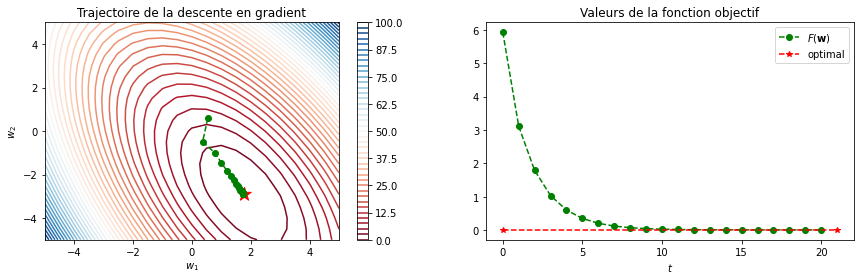

In [49]:
w_history, loss_history = optimize(learning_rate, momentum, nesterov)
show_optimization(w_history, loss_history)

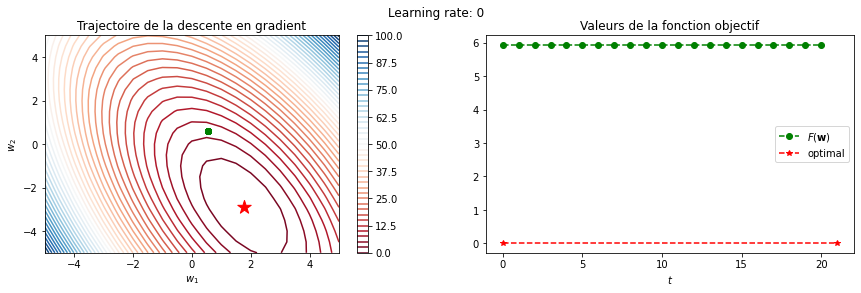

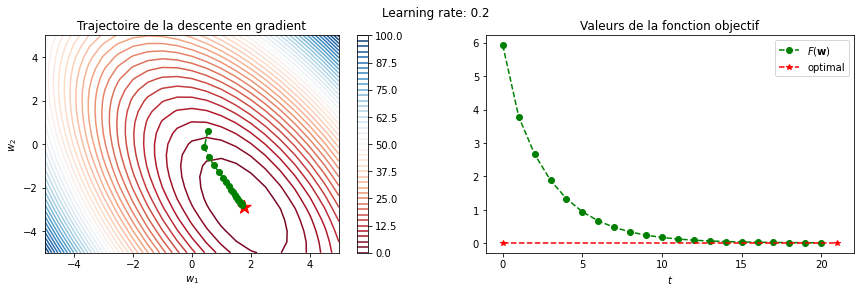

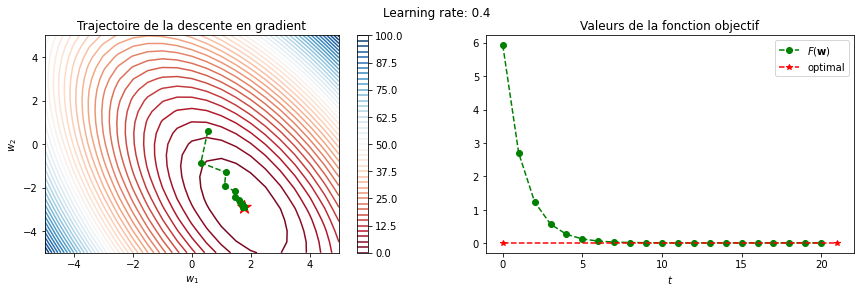

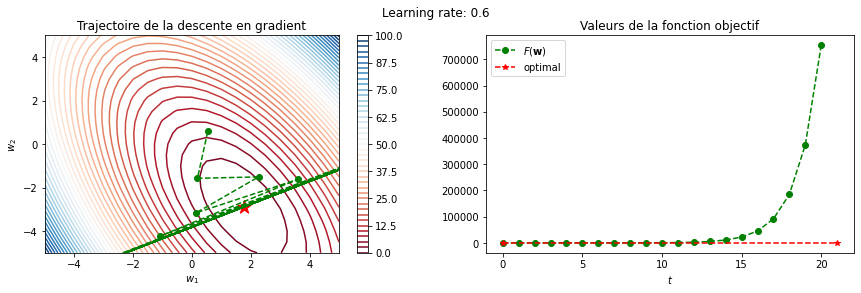

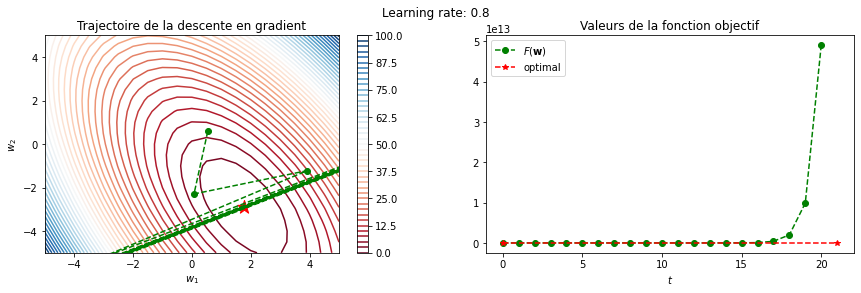

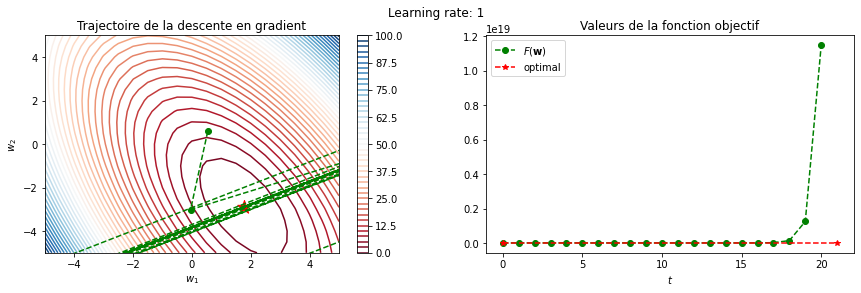

In [32]:
momentum = 0.
nesterov = False
#for learning_rate in [...]: # TODO à compléter avec différentes valeurs
for learning_rate in np.linspace(0., 1., 6):
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_optimization(w_history, loss_history, title=f"Learning rate: {learning_rate:.2g}")

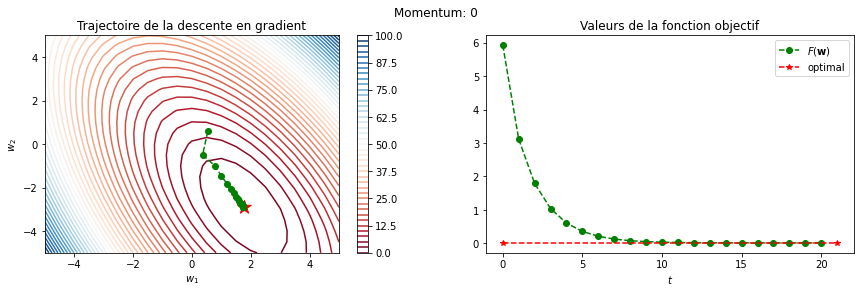

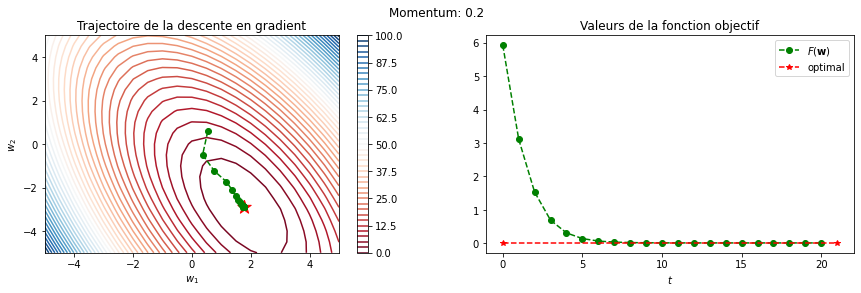

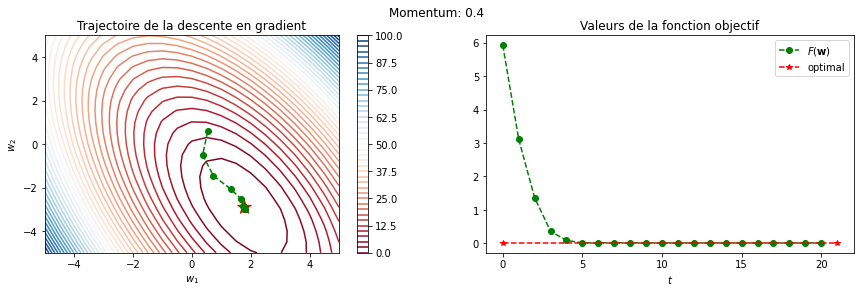

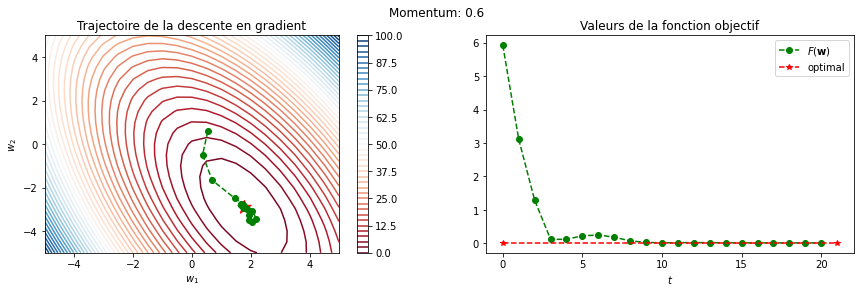

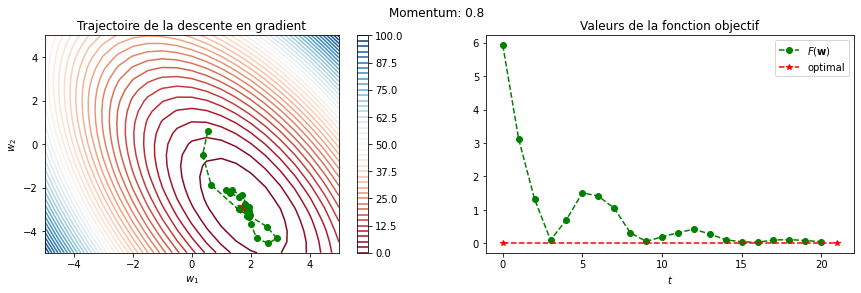

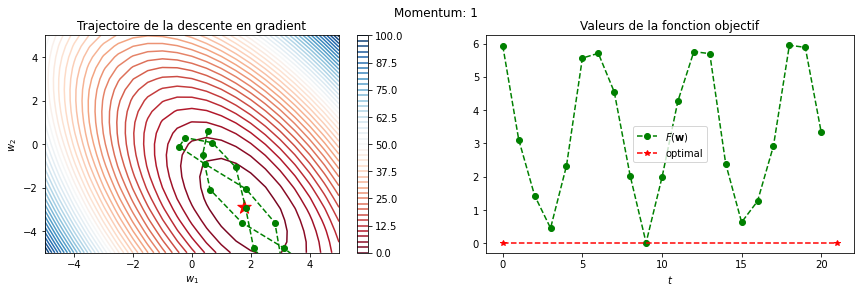

In [41]:
learning_rate = 0.3
nesterov = False
#for momentum in [...]: # TODO à compléter avec différentes valeurs
for momentum in np.linspace(0., 1., 6):
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_optimization(w_history, loss_history, title=f"Momentum: {momentum:.2g}")

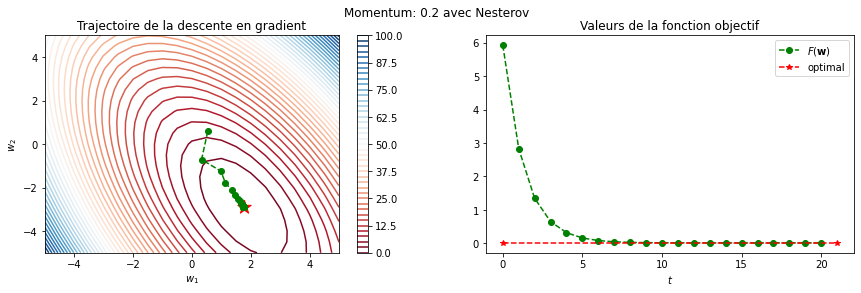

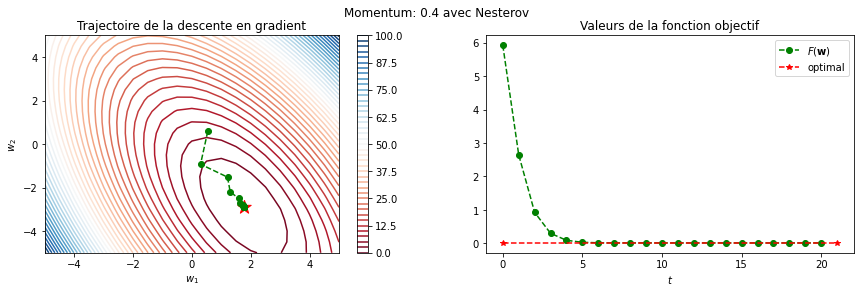

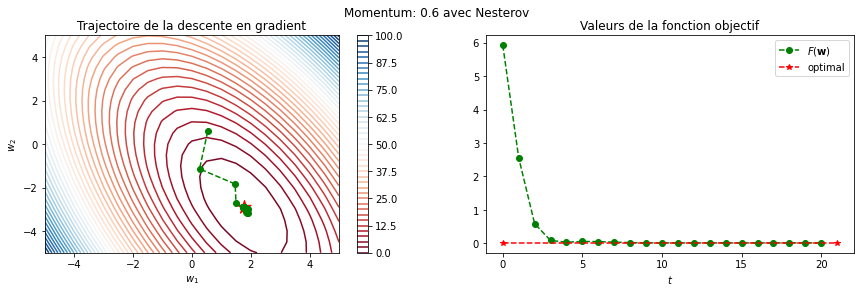

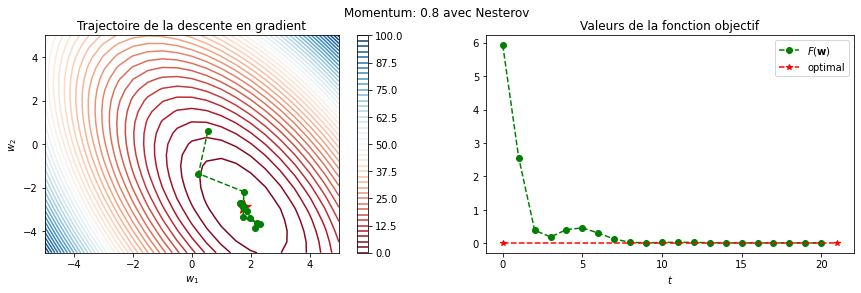

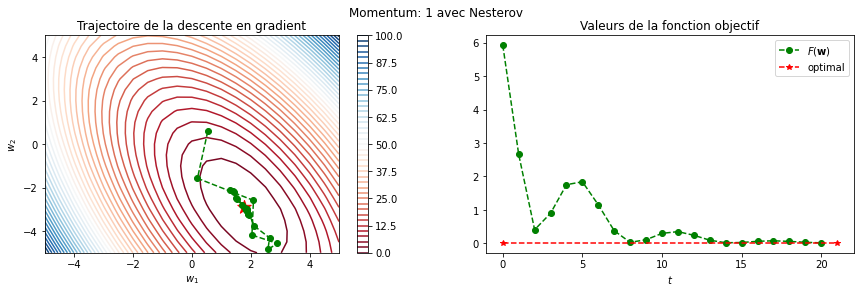

In [40]:
learning_rate = 0.3
nesterov = True
#for momentum in [...]: # TODO à compléter avec différentes valeurs
for momentum in np.linspace(0.2, 1., 5):
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_optimization(w_history, loss_history, title=f"Momentum: {momentum:.2g} avec Nesterov")

### Un exemple plus près de la réalité

Testons maintenant différents optimiseurs sur un vrai réseau de neurones avec un vrai jeu de données. Comme dans les labos précédents, on utilise le jeu de données CIFAR10 avec un simple réseau à convolution.

Initialisons le jeu de données et quelques hyperparamètres qui vont rester constant.

In [50]:
cifar_train, cifar_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 128
lr = 0.01
n_epoch = 10

#### Exercice

Comparez trois différentes stratégies d'optimisation:
1. [SGD](http://pytorch.org/docs/master/optim.html#torch.optim.SGD)
2. SGD + Momentum accéléré de Nesterov
3. [Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam) 

Commençons par l'entraîner avec SGD.

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.78s loss: 2.262443 acc: 16.345000 val_loss: 2.156723 val_acc: 24.190000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 2.035539 acc: 27.072500 val_loss: 1.972576 val_acc: 30.690000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.61s loss: 1.939469 acc: 31.420000 val_loss: 1.950620 val_acc: 31.030000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.60s loss: 1.840814 acc: 35.207500 val_loss: 1.828352 val_acc: 35.000000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.66s loss: 1.741715 acc: 38.637500 val_loss: 1.683923 val_acc: 39.910000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.62s loss: 1.663055 acc: 41.212500 val_loss: 1.649824 val_acc: 41.330000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.65s loss: 1.593210 acc: 43.757500 val_loss: 1.709768 val_acc: 39.690000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

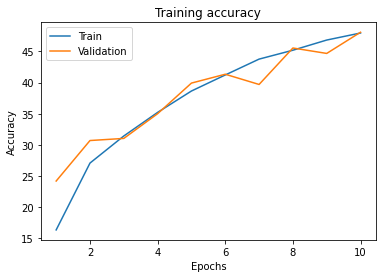

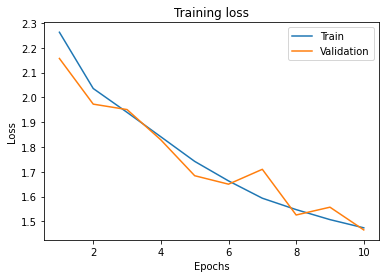

Précision en test: 49.57


In [4]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)
history_sgd = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_sgd.display_accuracy()
history_sgd.display_loss()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

Complétez cette cellule pour entraîner avec SGD + Momentum accéléré de Nesterov. Utilisez un momentum de 0.9.

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 1.859163 acc: 33.012500 val_loss: 1.561596 val_acc: 43.960000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.409060 acc: 50.095000 val_loss: 1.312549 val_acc: 53.400000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.222650 acc: 57.092500 val_loss: 1.175941 val_acc: 58.580000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.72s loss: 1.081008 acc: 62.250000 val_loss: 1.113444 val_acc: 60.120000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 0.971967 acc: 66.125000 val_loss: 1.086406 val_acc: 62.180000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.68s loss: 0.884140 acc: 69.612500 val_loss: 0.963158 val_acc: 66.440000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 0.810111 acc: 71.927500 val_loss: 0.939169 val_acc: 67.970000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

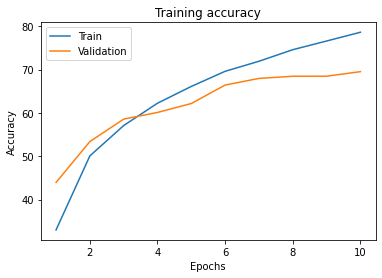

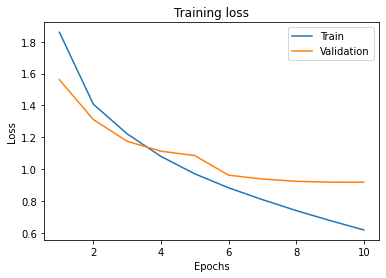

Précision en test: 69.13


In [5]:
model = CifarNet()
model.cuda()
#optimizer =
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
history_SGDMN = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_SGDMN.display_accuracy()
history_SGDMN.display_loss()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

Complétez cette cellule pour entraîner avec Adam

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.88s loss: 1.961768 acc: 28.242500 val_loss: 1.790942 val_acc: 34.480000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.679835 acc: 39.847500 val_loss: 1.602009 val_acc: 44.060000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.82s loss: 1.565242 acc: 44.732500 val_loss: 1.527300 val_acc: 45.830000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.81s loss: 1.497094 acc: 46.785000 val_loss: 1.498500 val_acc: 46.550000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.82s loss: 1.438372 acc: 49.142500 val_loss: 1.459651 val_acc: 48.440000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.73s loss: 1.415032 acc: 49.820000 val_loss: 1.429049 val_acc: 49.960000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.73s loss: 1.384751 acc: 51.120000 val_loss: 1.419368 val_acc: 49.720000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

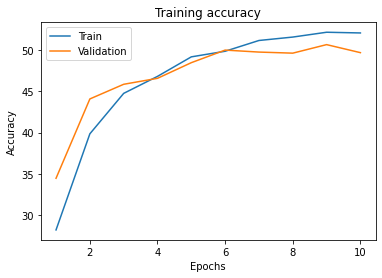

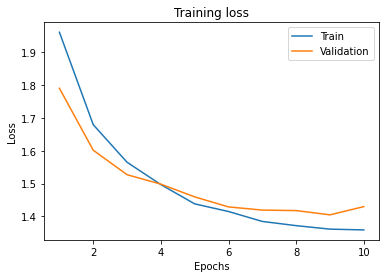

Précision en test: 49.91


In [6]:
model = CifarNet()
model.cuda()
#optimizer =
optimizer = optim.Adam(model.parameters(), lr=lr)
history_adam = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_adam.display_accuracy()
history_adam.display_loss()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Questions
- Quelle méthode semble être la meilleure dans ce cas-ci? **Les résultats peuvent varier en fonction de l'initialisation. Dans ce corrigé, on remarque que l'exactitude en validation et en test de SGD + Momentum accéléré de Nesterov est la meilleur suivies de Adam qui est très proche de de SGD seul.**
- Remarquez-vous une différence d'overfitting? **On remarque une grande différence entre les perte d'entraînement et de validation pour SGD + Momentum accéléré de Nesterov alors que la différence est quasiment nulle pour SGD alors que Adam est entre les deux. Encore une fois, les résultats peuvent varier en fonction de l'initialisation.**

**Il est a noté que si l'on changeait l'architecture, les données, la tâche ou tout autre hyperparamètre, la performance des optimiseurs va varier.**

## 2. Horaire d'entraînement

Une pratique courante utilisé en deep learning est de faire diminuer le learning rate pendant l'entraînement.

Pour ce faire PyTorch fourni plusieurs fonctions (ExponentialLR, LambdaLR, MultiStepLR, etc.)

Voici un exemple avec ExponentialLR.

In [7]:
model = CifarNet()
model.cuda()

batch_size = 128
lr = 0.01
n_epoch = 10

optimizer = optim.SGD(model.parameters(), lr=lr)

gamma = 0.99
scheduler = pt.ExponentialLR(gamma)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 2.241869 acc: 18.715000 val_loss: 2.091969 val_acc: 27.470000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.69s loss: 2.016405 acc: 27.692500 val_loss: 1.997186 val_acc: 27.890000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 1.939193 acc: 31.237500 val_loss: 1.896901 val_acc: 33.710000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.863564 acc: 34.460000 val_loss: 1.835212 val_acc: 35.110000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.72s loss: 1.791668 acc: 36.815000 val_loss: 1.765953 val_acc: 37.880000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.72s loss: 1.730383 acc: 38.770000 val_loss: 1.707336 val_acc: 40.720000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.68s loss: 1.671523 acc: 41.442500 val_loss: 1.669641 val_acc: 41.350000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

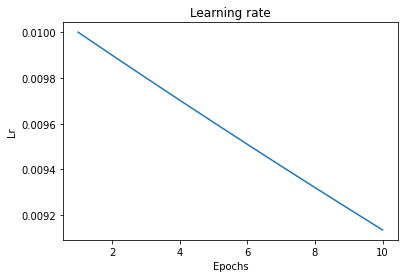

In [8]:
history.display_lr()

#### Exercice

Utilisez [MultiStepLR](http://pytorch.org/docs/master/optim.html#torch.optim.lr_scheduler.MultiStepLR) pour modifier le learning rate un epoch précis. 

1. Commencez avec un learning rate trop élevé pour que le réseau puisse apprendre quelque chose.
2. Diminuez le progressivement jusqu'à ce que le réseau apprenne.
3. Trouvez le moment où la validation semble avoir atteint un plateau.
4. Diminuez le learning par 2 à ce moment et réentraîner le réseau.

In [9]:
torch.manual_seed(42)
model = CifarNet()
model.cuda()

#epoch_list = []
epoch_list = [8, 11, 12]

batch_size = 128
#lr = 10
lr = 0.5
n_epoch = 20

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = pt.MultiStepLR(milestones=epoch_list, gamma=0.5, verbose=True)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 1/20 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 2.118420 acc: 21.765000 val_loss: 1.827306 val_acc: 34.590000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 2/20 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.732751 acc: 38.430000 val_loss: 1.685035 val_acc: 41.820000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 3/20 Step: 313/313 100.00% |█████████████████████████|5.71s loss: 1.510473 acc: 46.660000 val_loss: 1.460131 val_acc: 48.220000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 4/20 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 1.340647 acc: 52.842500 val_loss: 1.535631 val_acc: 45.570000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 5/20 Step: 313/313 100.00% |█████████████████████████|5.67s loss: 1.218174 acc: 57.395000 val_loss: 1.307623 val_acc: 55.650000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 6/20 Step: 313/313

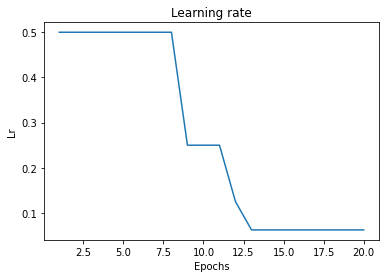

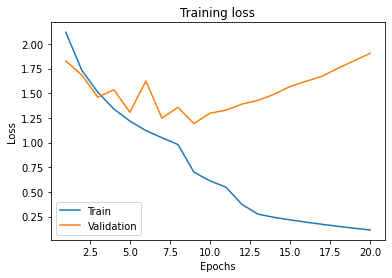

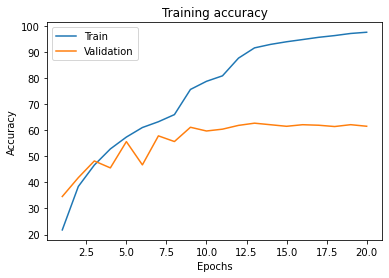

In [10]:
history.display_lr()
history.display_loss()
history.display_accuracy()

#### Questions
- Voyez-vous une différence en diminuant le learning rate par 2 après x epochs?<br>
- Pourquoi?

## 3. Batch Normalization

Voici l'architecture du réseau de neurones convolutionnels que vous avez utilisé jusqu'à présent pour faire de la classification sur Cifar10.

In [11]:
import torch.nn.functional as F

class CifarNetBatchNorm(nn.Module):
    def __init__(self):
        super(CifarNetBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 50, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(50)
        self.conv3 = nn.Conv2d(50, 150, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(150)
        self.fc1 = nn.Linear(150 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    @staticmethod
    def num_flat_features(x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#### Exercice

Modifier l'architecture du réseau en ajoutant de la batch norm entre les couches de convolutions et entraîner le nouveau réseau.

Comparer l'entraînement du réseau avec et sans la batch norm (Section 1 avec SGD).<br>
Que remarquez-vous?<br>

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|6.42s loss: 1.550439 acc: 45.980000 val_loss: 1.519981 val_acc: 47.780000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|6.19s loss: 1.137459 acc: 59.647500 val_loss: 1.109996 val_acc: 60.570000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|6.14s loss: 0.984522 acc: 65.687500 val_loss: 1.453939 val_acc: 51.450000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|6.05s loss: 0.884599 acc: 69.485000 val_loss: 1.019770 val_acc: 64.280000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|6.00s loss: 0.817045 acc: 71.947500 val_loss: 1.223238 val_acc: 59.810000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.99s loss: 0.755300 acc: 74.267500 val_loss: 1.398866 val_acc: 54.260000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.94s loss: 0.708255 acc: 76.132500 val_loss: 1.028270 val_acc: 65.290000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

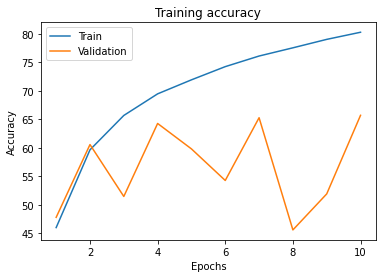

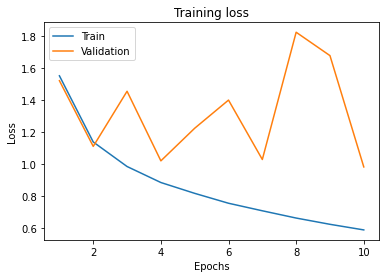

In [12]:
model = CifarNetBatchNorm()
model.cuda()

lr = 0.01
batch_size = 128
n_epoch = 10

optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history.display_accuracy()
history.display_loss()

### Effet de la batch norm sur le learning rate

Commençons par entraîner un réseau avec un haut learning rate.

In [13]:
lr = 0.5
batch_size = 1024
n_epoch = 10

In [14]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

Epoch: 1/10 Step: 40/40 100.00% |█████████████████████████|5.03s loss: 2.329892 acc: 11.897500 val_loss: 2.302342 val_acc: 10.680000
Epoch: 2/10 Step: 40/40 100.00% |█████████████████████████|5.08s loss: 2.283820 acc: 13.907500 val_loss: 2.229220 val_acc: 17.890000
Epoch: 3/10 Step: 40/40 100.00% |█████████████████████████|5.02s loss: 2.148841 acc: 21.925000 val_loss: 2.652889 val_acc: 15.520000
Epoch: 4/10 Step: 40/40 100.00% |█████████████████████████|5.02s loss: 2.056845 acc: 26.225000 val_loss: 2.071516 val_acc: 28.860000
Epoch: 5/10 Step: 40/40 100.00% |█████████████████████████|5.02s loss: 1.931160 acc: 31.357500 val_loss: 1.857863 val_acc: 32.700000
Epoch: 6/10 Step: 40/40 100.00% |█████████████████████████|5.07s loss: 1.827252 acc: 34.587500 val_loss: 2.163026 val_acc: 22.610000
Epoch: 7/10 Step: 40/40 100.00% |█████████████████████████|4.94s loss: 1.768505 acc: 36.782500 val_loss: 1.971764 val_acc: 31.220000
Epoch: 8/10 Step: 40/40 100.00% |█████████████████████████|4.93s loss

Essayons maintenant d'entraîner le réseau utilisant la batchnorm avec les mêmes hyperparamètres.

In [15]:
model = CifarNetBatchNorm()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

Epoch: 1/10 Step: 40/40 100.00% |█████████████████████████|5.20s loss: 5.279598 acc: 15.277500 val_loss: 2.211200 val_acc: 19.980000
Epoch: 2/10 Step: 40/40 100.00% |█████████████████████████|5.25s loss: 1.961254 acc: 28.360000 val_loss: 2.413215 val_acc: 21.860000
Epoch: 3/10 Step: 40/40 100.00% |█████████████████████████|5.19s loss: 1.753062 acc: 36.545000 val_loss: 2.747171 val_acc: 20.880000
Epoch: 4/10 Step: 40/40 100.00% |█████████████████████████|5.19s loss: 1.642056 acc: 40.947500 val_loss: 2.879700 val_acc: 20.970000
Epoch: 5/10 Step: 40/40 100.00% |█████████████████████████|5.24s loss: 1.538410 acc: 44.585000 val_loss: 3.349772 val_acc: 20.160000
Epoch: 6/10 Step: 40/40 100.00% |█████████████████████████|5.19s loss: 1.500580 acc: 46.577500 val_loss: 2.110616 val_acc: 33.120000
Epoch: 7/10 Step: 40/40 100.00% |█████████████████████████|5.20s loss: 1.459386 acc: 48.152500 val_loss: 1.731886 val_acc: 41.990000
Epoch: 8/10 Step: 40/40 100.00% |█████████████████████████|5.25s loss

#### Questions
- Que pouvez-vous conclure sur l'effet de la batch norm sur le learning rate?

### Analyse

Après l'entraînement, il est important d'analyser les résultats obtenus.
Commençons par tester le réseau en utilisant la fonction `validate_ranking`.
Cette fonction sépare les résultats bien classés des erreurs et retourne pour chaque image, un score (qu'on peut voir comme une probabilité), la vraie classe et la classe prédite.

In [16]:
good, errors = validate_ranking(model, cifar_test, batch_size, use_gpu=True)

Maintenant, regardons quelques exemples d'images bien classées.

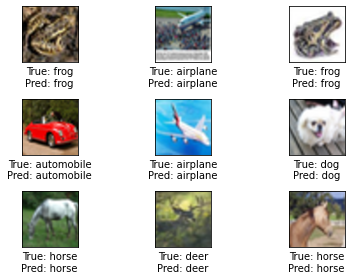

In [17]:
show_random(good)

Et quelques exemples mal classées.

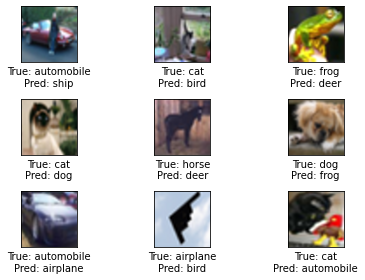

In [18]:
show_random(errors)

Il est aussi possible de regarder les exemples où le réseau est le plus confiant.

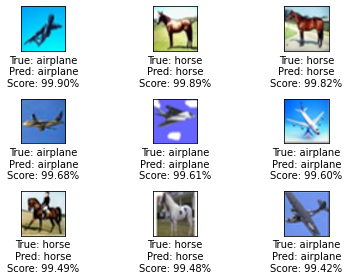

In [19]:
show_best(good)

Ou l'inverse, ceux qui ont obtenus les moins bons scores.

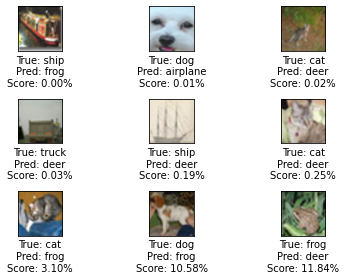

In [20]:
show_worst(errors)

Finalement, il peut être intéressant de regarder les exemples les plus difficiles.
Soit ceux qui ont été bien classé, mais qui ont eu un mauvais score.

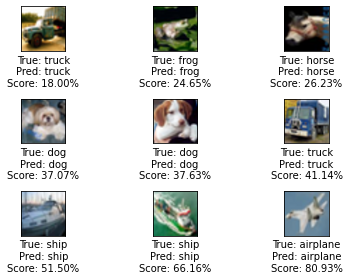

In [21]:
show_worst(good)

Ou ceux qui été mal classé, mais qui ont quand même réussi à obtenir un bon score.

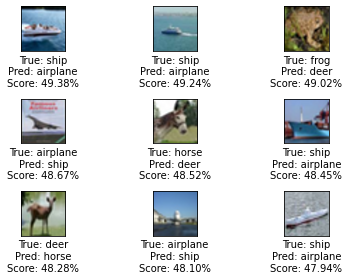

In [22]:
show_best(errors)

#### Questions 
- En observant les résultats obtenus, que pouvez-vous dire sur les performances du réseau? <br>
- Quelle classe semble être facile? Pourquoi? <br>
- Quelle classe semble être difficile? Pourquoi? <br>